<a href="https://colab.research.google.com/github/FunmilolaAdetuwo/Final-Project/blob/main/Advanced_AI_Techniques_for_Predicting_Currency_Exchange_Rates_A_Deep_Learning_Approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Instal the World bank library

!pip install wbdata

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 7.3 MB/s eta 0:00:00
  Attempting uninstall: tabulate
    Found existing installation: tabulate 0.9.0
    Uninstalling tabulate-0.9.0:
      Successfully uninstalled tabulate-0.9.0
  Attempting uninstall: decorator
    Found existing installation: decorator 4.4.2
    Uninstalling decorator-4.4.2:
      Successfully uninstalled decorator-4.4.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.
bigframes 1.24.0 requires tabulate>=0.9, but you have tabulate 0.8.10 which is incompatible.
moviepy 1.0.3 requires decorator<5.0,>=4.0.2, but you have decorator 5.1.1 which is incompatible.


In [50]:
# Importing necessary libraries

import yfinance as yf
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import wbdata as wb
import seaborn as sns
import matplotlib.dates as mdates

First, we will be fetching the currency data from the Yahoo Finance.
The GBP and the USD will be the currency that will be used for this project
The period that will be used for this project will be from 01 January 2004 to 31 December 2023

In [40]:
# Defining the ticker symbol for GBP/USD
tcker_symb = "GBPUSD=X"

# Setting the data range
strt_dt = "2004-01-01"
ed_dt = "2023-12-31"

# Fetching the data
crcy_dt = yf.download(tcker_symb, start=strt_dt, end=ed_dt)

# setting the index to convert the index to a date column
crcy_dt.reset_index(inplace=True)

# Flattening the columns
crcy_dt.columns = ['_'.join(col).strip() if col[1] else col[0] for col in crcy_dt.columns.values]

crcy_dt['Date'] = pd.to_datetime(crcy_dt['Date'])


# Display the data structure after modification
print("Data after flattening columns and setting 'Date':")
print(crcy_dt.head())

[*********************100%***********************]  1 of 1 completed

Data after flattening columns and setting 'Date':
                       Date  Adj Close_GBPUSD=X  Close_GBPUSD=X  \
0 2004-01-01 00:00:00+00:00            1.785204        1.785204   
1 2004-01-02 00:00:00+00:00            1.793690        1.793690   
2 2004-01-05 00:00:00+00:00            1.807207        1.807207   
3 2004-01-06 00:00:00+00:00            1.821295        1.821295   
4 2004-01-07 00:00:00+00:00            1.817785        1.817785   

   High_GBPUSD=X  Low_GBPUSD=X  Open_GBPUSD=X  Volume_GBPUSD=X  
0       1.788813      1.781705       1.788813                0  
1       1.795010      1.779201       1.785587                0  
2       1.810315      1.795107       1.795493                0  
3       1.827786      1.805510       1.807403                0  
4       1.825584      1.812711       1.820897                0  


Now, using the same period, we will fetch the macro economic data from the World bank for the United Kingdom and United States.

The indicators to be used is the GDP and Inflation rate.

In [41]:
# Setting the date range
dt_dte = ("2004", "2023")

# Getting the GDP and Inflation data for US and UK
gdp_dt = wb.get_data("NY.GDP.MKTP.CD", country=['GBR', 'USA'], date=dt_dte)
ifltn_dt = wb.get_data("FP.CPI.TOTL.ZG", country=['GBR', 'USA'], date=dt_dte)

# Converting this into DataFrames
gdp_df = pd.DataFrame(gdp_dt)
ifltn_df = pd.DataFrame(ifltn_dt)

def extract_dict_value(row, key):
    return row[key]['value'] if isinstance(row[key], dict) else row[key]

gdp_df['country'] = gdp_df['country'].apply(extract_dict_value, key='value')
gdp_df['indicator'] = gdp_df['indicator'].apply(extract_dict_value, key='value')

ifltn_df['country'] = ifltn_df['country'].apply(extract_dict_value, key='value')
ifltn_df['indicator'] = ifltn_df['indicator'].apply(extract_dict_value, key='value')

gdp_df['date'] = pd.to_datetime(gdp_df['date'])
ifltn_df['date'] = pd.to_datetime(ifltn_df['date'])

gdp_pt = gdp_df.pivot(index='date', columns='country', values='value').rename(columns=lambda x: f"GDP_{x}")
ifltn_pt = ifltn_df.pivot(index='date', columns='country', values='value').rename(columns=lambda x: f"Inflation_{x}")

# Merging the GDP and Inflation data into a single DataFrame
ecomc_dt = gdp_pt.join(ifltn_pt, how='outer')

# Displaying the data
print(ecomc_dt.head())


country     GDP_United Kingdom  GDP_United States  Inflation_United Kingdom  \
date                                                                          
2004-01-01        2.421525e+12       1.221720e+13                  1.390398   
2005-01-01        2.543180e+12       1.303920e+13                  2.089136   
2006-01-01        2.708442e+12       1.381558e+13                  2.455662   
2007-01-01        3.090510e+12       1.447423e+13                  2.386562   
2008-01-01        2.929412e+12       1.476986e+13                  3.521409   

country     Inflation_United States  
date                                 
2004-01-01                 2.677237  
2005-01-01                 3.392747  
2006-01-01                 3.225944  
2007-01-01                 2.852672  
2008-01-01                 3.839100  


The Currency data and the Macroeconomic data is merged together.
The daily exchange rate data of GBP/USD with annual GDP and inflation data for the UK and the US was merged together. In this integration, there is high-frequency daily data, which shows trends in currency exchange rate, with lower-frequency annual data that shows the macro economic data.

The datasets are different in frequency—daily for exchange rates and annually for macro economic indicators. This was aligned by using a forward fill method, which carries forward the last known annual values until new data becomes available. This means every daily exchange rate from January 1, 2004, to December 29, 2023, is associated with the latest annual macro economic data.


In [45]:
crcy_dt['Date'] = crcy_dt['Date'].dt.tz_localize(None)
ecomc_dt.index = ecomc_dt.index.tz_localize(None)

# Merging the daily currency data with the economic data using forward fill to handle the missing daily values
cmbd_dt = pd.merge(crcy_dt, ecomc_dt, left_on='Date', right_index=True, how='left')
cmbd_dt.fillna(method='ffill', inplace=True)

# Displaying the combined data
print(cmbd_dt.head())



        Date  Adj Close_GBPUSD=X  Close_GBPUSD=X  High_GBPUSD=X  Low_GBPUSD=X  \
0 2004-01-01            1.785204        1.785204       1.788813      1.781705   
1 2004-01-02            1.793690        1.793690       1.795010      1.779201   
2 2004-01-05            1.807207        1.807207       1.810315      1.795107   
3 2004-01-06            1.821295        1.821295       1.827786      1.805510   
4 2004-01-07            1.817785        1.817785       1.825584      1.812711   

   Open_GBPUSD=X  Volume_GBPUSD=X  GDP_United Kingdom  GDP_United States  \
0       1.788813                0        2.421525e+12       1.221720e+13   
1       1.785587                0        2.421525e+12       1.221720e+13   
2       1.795493                0        2.421525e+12       1.221720e+13   
3       1.807403                0        2.421525e+12       1.221720e+13   
4       1.820897                0        2.421525e+12       1.221720e+13   

   Inflation_United Kingdom  Inflation_United States  
0

<ipython-input-45-14d50c9c106e>:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  cmbd_dt.fillna(method='ffill', inplace=True)


**Exploratory Data Analysis (EDA)**

The EDA shows that the dataset contains 5,200 entries. The dataset does not contain any null value- there is no missing value as we have addressed it earlier.The data types shows that the date column uses datetime64[ns] format while the numerical data is stored as a float which is suitable for a time series analysis.

The GBP/USD exchange rate trends graph shows the change in the exchange rate over the years, it captures significant movement in the currency. The ups and downs highlight periods of volatility, which may correspond to macro economic events affecting the currencies.

The GDP trends graphs shows in a step-chart format, the GDP for each country showing an incremental change on a  year by year basis. The UK's GDP is consistently lower than that of the US, showing the larger scale of the US economy compared to the UK. The graph shows economic growth periods and potential declines.

The Inflation rate trend graph shows how inflation has varied over the years in both UK and US. The graph shows periods of higher inflation, which often correlates with economic policies.

The distribution of GBP/USD exchange rates graph shows that the majority of exchange values is centred around the 1.3 mark, indicating a left-skewed distribution, suggesting that the British pound normally traded at this rate in relation to the US dollar. The spread towards lower values around 1.1 indicates times of relative weakness in the pound, while peaks around 1.5 indicate sporadic periods of higher exchange rates.

The GDP distributions for the US and the UK graph shows that the US GDP exhibits a greater variance over higher values, with peaks around 2 trillion USD, the UK's GDP distribution exhibits tight clustering around lower values (between 0.3 and 0.5 trillion). With the US economy continuously functioning at a larger scale than the UK across the period, this discrepancy emphasises an economic size gap.

The GBP/USD exchange rate box plot indicates that the median value is approximately 1.5, with most values falling between 1.4 and 1.6. The "whiskers" extend to just above 2.0 and below 1.2, showing the full data range without extreme outliers.


In [48]:
# Displaying the descriptive statistics of the combined dataset
print(cmbd_dt.describe())

# checkingto see non-null and data types
print(cmbd_dt.info())


       Adj Close_GBPUSD=X  Close_GBPUSD=X  High_GBPUSD=X  Low_GBPUSD=X  \
count         5200.000000     5200.000000    5200.000000   5200.000000   
mean             1.538863        1.538863       1.544632      1.532616   
std              0.239130        0.239130       0.239782      0.238861   
min              1.072754        1.072754       1.083541      0.637389   
25%              1.314488        1.314488       1.319575      1.309925   
50%              1.541390        1.541390       1.547221      1.534755   
75%              1.682992        1.682992       1.686732      1.680072   
max              2.108192        2.108192       2.115820      2.098812   

       Open_GBPUSD=X  Volume_GBPUSD=X  GDP_United Kingdom  GDP_United States  \
count    5200.000000           5200.0        5.200000e+03       5.200000e+03   
mean        1.538840              0.0        2.757462e+12       1.751583e+13   
std         0.239111              0.0        2.665974e+11       3.770010e+12   
min         1

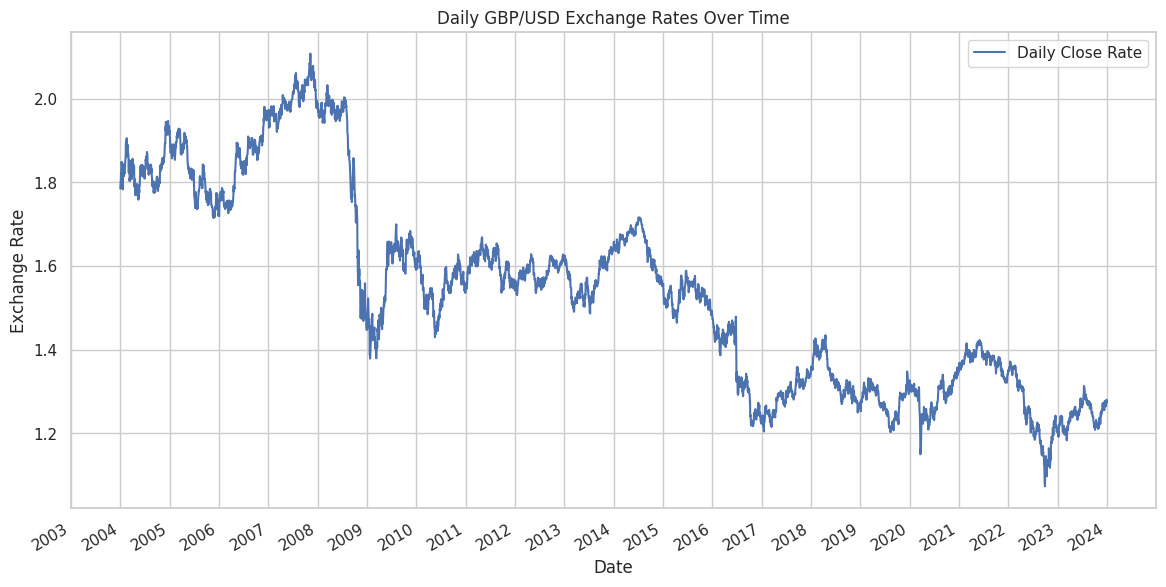

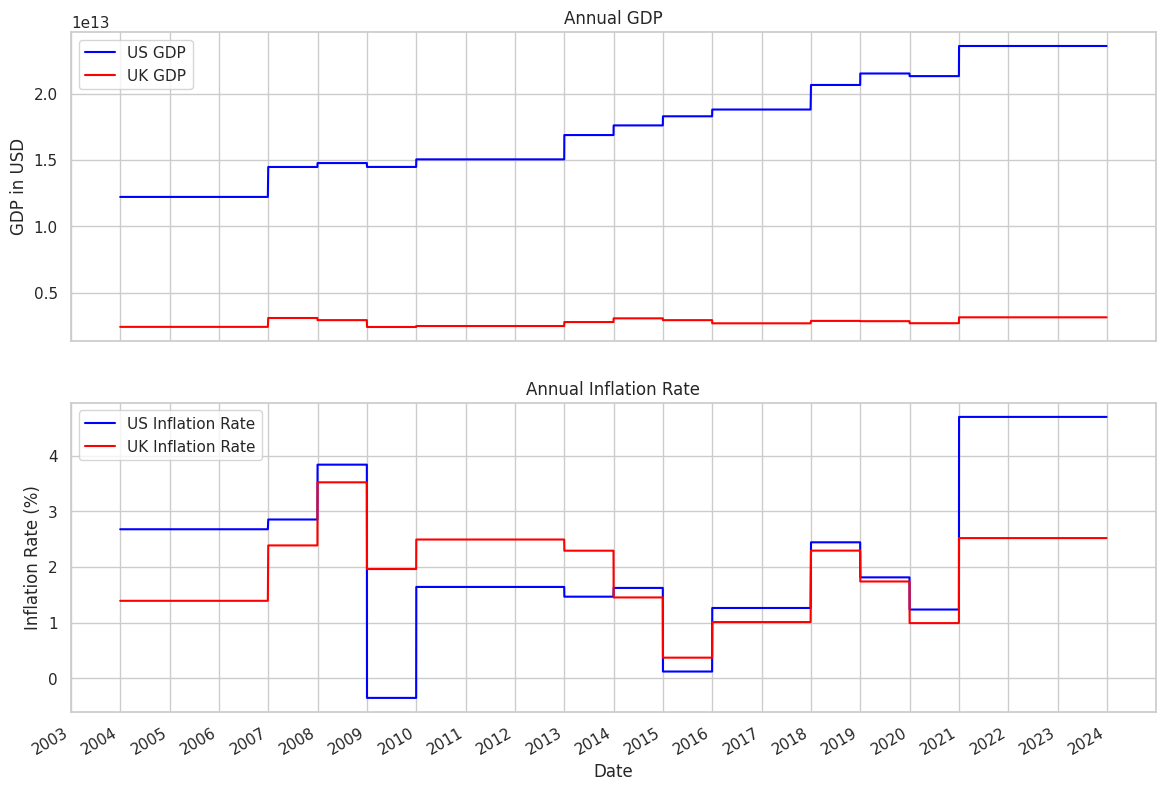

In [52]:
# Visualizing the dataset trends

# Setting the style
sns.set(style="whitegrid")

# Plotting the currency exchange rates
plt.figure(figsize=(14, 7))
plt.plot(cmbd_dt.index, cmbd_dt['Close_GBPUSD=X'], label='Daily Close Rate')
plt.title('Daily GBP/USD Exchange Rates Over Time')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()

# Setting the date format on x-axis
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gcf().autofmt_xdate()

plt.show()

# Plotting GDP and Inflation trends
fig, ax = plt.subplots(2, 1, figsize=(14, 10), sharex=True)
ax[0].plot(cmbd_dt.index, cmbd_dt['GDP_United States'], label='US GDP', color='blue')
ax[0].plot(cmbd_dt.index, cmbd_dt['GDP_United Kingdom'], label='UK GDP', color='red')
ax[0].set_title('Annual GDP')
ax[0].set_ylabel('GDP in USD')
ax[0].legend()

ax[1].plot(cmbd_dt.index, cmbd_dt['Inflation_United States'], label='US Inflation Rate', color='blue')
ax[1].plot(cmbd_dt.index, cmbd_dt['Inflation_United Kingdom'], label='UK Inflation Rate', color='red')
ax[1].set_title('Annual Inflation Rate')
ax[1].set_ylabel('Inflation Rate (%)')
ax[1].set_xlabel('Date')
ax[1].legend()

# Setting the date format on x-axis for the subplot
ax[1].xaxis.set_major_locator(mdates.YearLocator())
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
fig.autofmt_xdate()

plt.show()


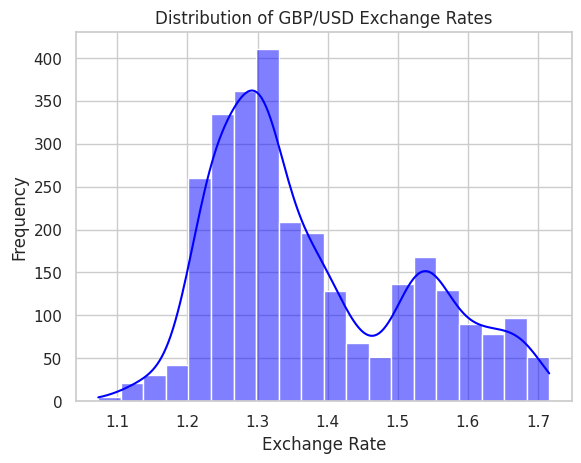

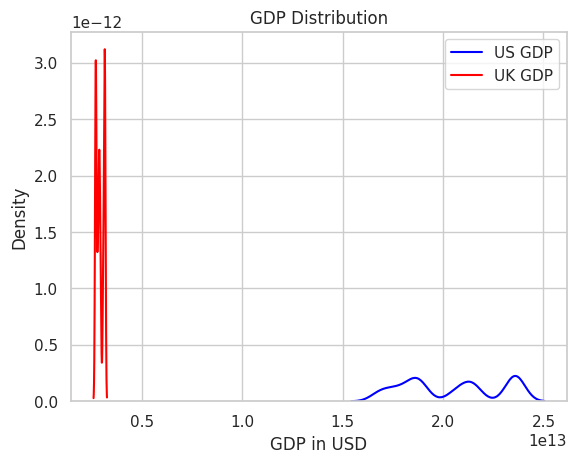

In [30]:
# Analyzing the distribution of the key variables

# plotting histogram for the exchange rates
sns.histplot(cmbd_dt['Close_GBPUSD=X'], kde=True, color='blue')
plt.title('Distribution of GBP/USD Exchange Rates')
plt.xlabel('Exchange Rate')
plt.ylabel('Frequency')
plt.show()

# Kernel density estimate for the GDP data
sns.kdeplot(cmbd_dt['GDP_United States'], label='US GDP', color='blue')
sns.kdeplot(cmbd_dt['GDP_United Kingdom'], label='UK GDP', color='red')
plt.title('GDP Distribution')
plt.xlabel('GDP in USD')
plt.ylabel('Density')
plt.legend()
plt.show()



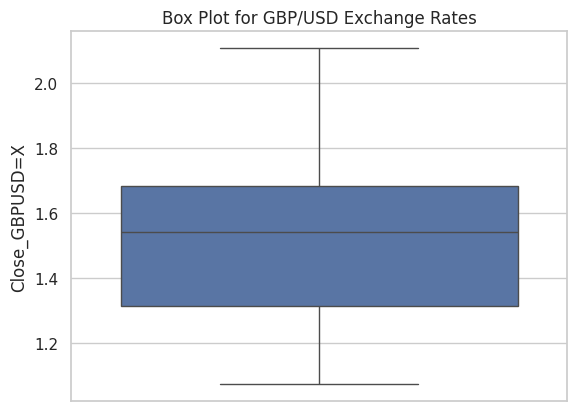

In [53]:
# checking for any outliers or anomalies
sns.boxplot(data=cmbd_dt['Close_GBPUSD=X'])
plt.title('Box Plot for GBP/USD Exchange Rates')
plt.show()


**Feature Engineering**